In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

PROM_URL = "http://vmquery"

In [16]:
## 1. Adquisición de Datos
# Conexion a nuestra instancia de Prometheus

promConn = PrometheusConnect(url = PROM_URL, disable_ssl=True)

# Obtener DF Metrics Timeseries
def metric_query(labels, start_time, end_time, query):
    metric_data = promConn.get_metric_range_data(
        query,
        label_config=labels,
        start_time = start_time,
        end_time = end_time,
    )

    return MetricRangeDataFrame(metric_data)


In [17]:
# Consulta las metricas
labels = { 'job' : 'node-exporter', 'instance': '10.44.0.3:9100', 'mountpoint' : '/'}
start_time = parse_datetime("3d")
end_time = parse_datetime("now")
query = 'node_filesystem_avail_bytes'
    
df_prom = metric_query(labels, start_time, end_time, query)

In [18]:
# 2. Inspeccion y preparacion de los datos

# Seleccionamos las columnas que necesitamos para el analisis
df = df_prom[['value']].copy()
df = df.set_index(df_prom.index)

df = df.resample('60T').mean()

# Normalizacion de datos en GB
df['value'] = df['value'] / 1024 / 1024 / 1024

# Dividir el DF (Metrics Timeseries) en datos de entrenamiento y de test
ratio = 0.2
size = int(len(df) * (1-float(ratio)))
df_train, df_test = df[0:size], df[size:len(df)]


In [19]:
# 3. Modelado

def ARIMA(df_datos, steps):
    #ARIMA order(0, 1, 1) seasonal_order(0, 1, 1, 12) | AIC: 188.95410490578703
    #ARIMA order(1, 1, 0) seasonal_order(0, 1, 1, 12) | AIC: 188.9630661935481
    #ARIMA order(0, 1, 0) seasonal_order(0, 1, 1, 12) | AIC: 187.2018820480008
    p = 0
    d = 1
    q = 0
    P = 0
    D = 1
    Q = 1
    m = 12
    
    model = SARIMAX(df_datos, order=(p, d, q), seasonal_order=(P,D,Q,m), enforce_stationarity = False, enforce_invertibility = False)
    results = model.fit(disp=False) #dsip=-1

    # Realizar el pronóstico para los próximos "steps"
    forecast = results.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    return results, pd.DataFrame(forecast_values, index = confidence_intervals.index), confidence_intervals


In [20]:
model, forecast, confidence_intervals = ARIMA(df, 24)

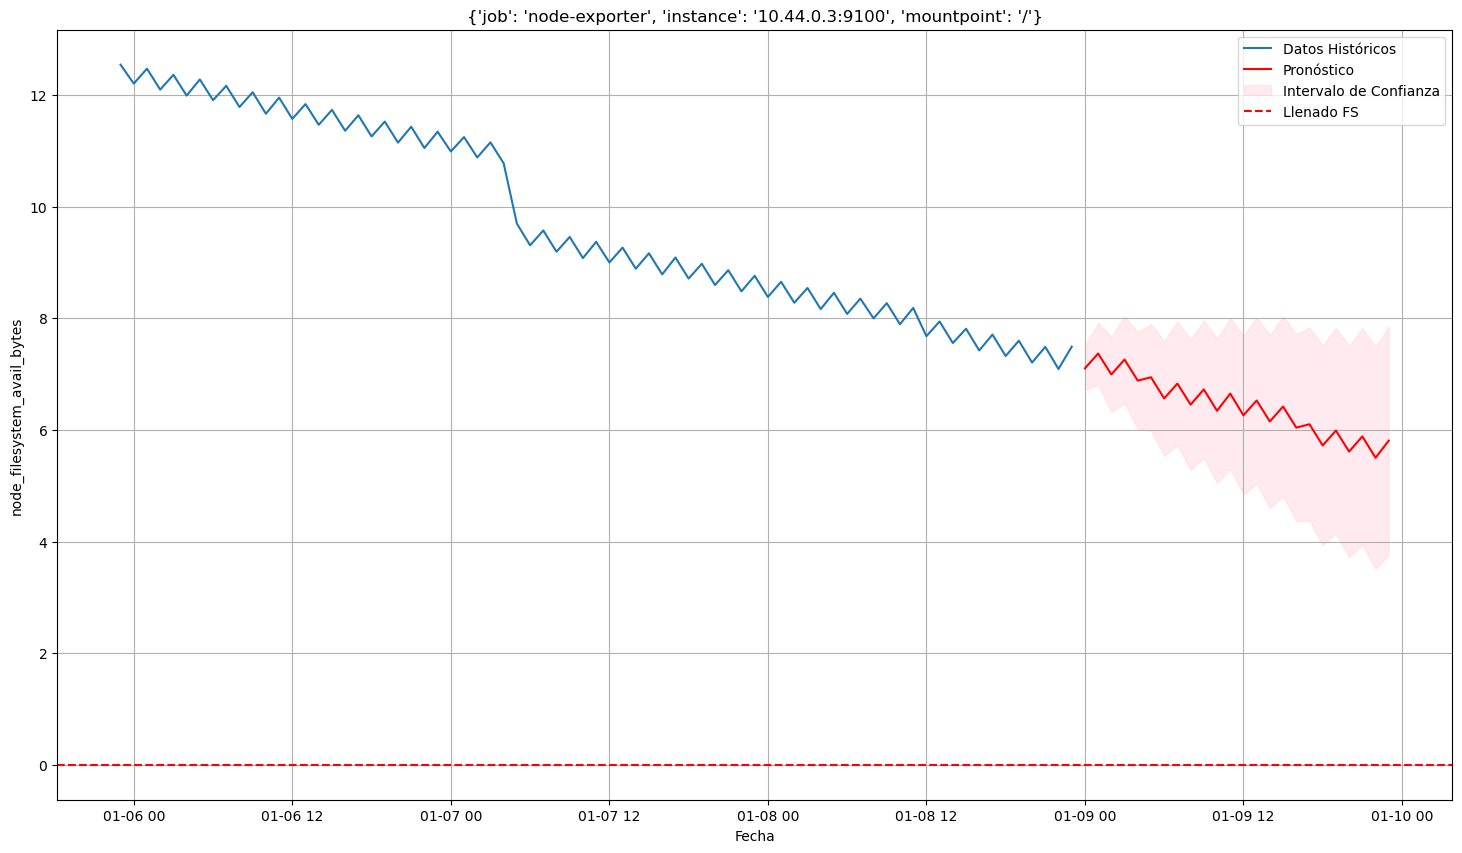

In [21]:
## 4. Visualización de los datos
# Datos históricos
plt.figure(figsize=(18, 10))
plt.plot(df, label='Datos Históricos')

# Pronóstico
plt.plot(forecast, color='red', label='Pronóstico')

# Intervalo de confianza
plt.fill_between(
    confidence_intervals.index, 
    confidence_intervals['lower value'],  
    confidence_intervals['upper value'], 
    color='pink', alpha=0.3, label='Intervalo de Confianza'
)

# Umbral
plt.axhline(y=0, color='red', linestyle='--', label='Llenado FS')

plt.xlabel('Fecha')
plt.ylabel(query)
plt.title(labels)
plt.legend()
plt.grid(True)
plt.show()